# Software Evolution - Practical Session
## Laws of software evolution based on code counting
## Academic year 2023-2024

### Write your answers under the questions that are present in this notebook  

#### Note: Print the final output of each cell in this notebook

#### Read the provided description document before proceeding with the following notebook

## 1.  Data preprocessing

To install packages, use :

pip install tqdm  pandas numpy matplotlib scikit-learn

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from permetrics.regression import RegressionMetric
from scipy.optimize import curve_fit

### Import dataset

First, import the dataset that contains the total lines of code, total blank lines, total comment lines, total number of files, and release date for each tag.

In [24]:
# WRITE YOUR CODE HERE
increasing = pd.read_csv("data/LawIncreasingGrowthDataset.csv")
# A = pd.read_csv("data/LawContinuingChangeDatasetA.csv")
# B = pd.read_csv("data/LawContinuingChangeDatasetB.csv")

In [25]:
increasing

,tag,code,blank,comment,nFiles,release_date
0,1.4,48551,8727,11154,419,2009-01-06
1,1.5.0,63240,11018,18457,512,2009-02-18
2,jaunty,70751,11840,19671,578,2009-06-23
3,1.5.1,67939,11618,18131,600,2009-08-05
4,1.5.2,68564,11555,11906,611,2009-08-17
...,...,...,...,...,...,...
56,4.3.1,456159,72232,219480,3405,2016-12-14
57,4.3.1.1,456159,72232,219480,3405,2017-02-02
58,4.4.0,472926,75325,216544,3597,2017-03-07
59,4.4.1,473836,75392,216678,3598,2017-05-08


### Dataset A : Major.Minor.Patch tag format

Filter out non-official releases such as alpha, beta, release candidates, milestones, branches, and unnumbered tags. Additionally, version numbers typically follow a Major.Minor.Patch format, but exceptions exist (e.g., 1.4, 3.3.0.1, 4.3.0.1, or 4.3.1.1). Versions with more than three components are disregarded, and two-component versions are treated as implicit three-component versions (e.g., 1.4 is interpreted as 1.4.0).  

Write a regular expression statement to identify tags following semantic versioning (major.minor.patch) guidelines. You can use the pattern: '^v?[0-9]+\.[0-9]+(\.[0-9]+)?$'  

Once you've applied this regex, print out the selected major.minor.patch dataset.

In [26]:
# WRITE YOUR CODE HERE
semantic_version_mask = increasing['tag'].str.match(r'^v?[0-9]+\.[0-9]+(\.[0-9]+)?$')

semantic_version_df = increasing[semantic_version_mask]

print(semantic_version_df)

      tag    code  blank  comment  nFiles release_date
0     1.4   48551   8727    11154     419   2009-01-06
1   1.5.0   63240  11018    18457     512   2009-02-18
3   1.5.1   67939  11618    18131     600   2009-08-05
4   1.5.2   68564  11555    11906     611   2009-08-17
6   1.6.1   86799  14582    41327     744   2009-11-05
9   2.0.0  115586  18488    42717    1074   2010-06-05
10  2.0.1  115699  18492    42724    1074   2010-07-06
21  3.0.0  188246  29836    60879    1694   2012-02-07
22  3.0.1  189022  29945    61587    1696   2012-03-12
26  3.1.0  191269  29973    62628    1642   2012-06-22
27  3.1.1  192026  30086    62931    1645   2012-09-17
28  3.1.2  192113  30101    62959    1646   2012-09-27
29  3.2.0  257934  43596   119688    2004   2012-12-17
33  3.2.1  260231  43992   120082    2011   2013-02-28
36  3.2.2  260173  43974   120045    2007   2013-04-16
38  3.3.0  350914  58798   159566    2682   2013-06-20
40  3.3.1  359678  60196   161364    2760   2013-09-11
41  3.3.2 

### Dataset B : Major.Minor tag format

Starting from the previous data (**Dataset A**),  for each Major.Minor.Patch tag group, select the earliest version (e.g., for a set of 4.4.0, 4.4.1, and 4.4.2, consider 4.4.0 and rename it to 4.4).

In [27]:
# WRITE YOUR CODE HERE
df = semantic_version_df
df['Major_Minor'] = df['tag'].apply(lambda x: '.'.join(x.split('.')[:2]))
earliest_versions = df.groupby('Major_Minor', as_index=False).first()
earliest_versions.drop(columns=['Major_Minor'], inplace=True)
earliest_versions['tag'] = earliest_versions['tag'].str.extract(r'^(\d+\.\d+)')
print(earliest_versions)

    tag    code  blank  comment  nFiles release_date
0   1.4   48551   8727    11154     419   2009-01-06
1   1.5   63240  11018    18457     512   2009-02-18
2   1.6   86799  14582    41327     744   2009-11-05
3   2.0  115586  18488    42717    1074   2010-06-05
4   3.0  188246  29836    60879    1694   2012-02-07
5   3.1  191269  29973    62628    1642   2012-06-22
6   3.2  257934  43596   119688    2004   2012-12-17
7   3.3  350914  58798   159566    2682   2013-06-20
8   3.4  291555  48371   149981    2367   2013-10-24
9   4.0  357375  57707   159944    2790   2014-05-30
10  4.1  419663  68854   208270    3283   2015-01-28
11  4.2  438240  71324   218459    3439   2015-10-22
12  4.3  455646  72172   219435    3405   2016-08-09
13  4.4  472926  75325   216544    3597   2017-03-07


/tmp/ipykernel_37082/1371023085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Major_Minor'] = df['tag'].apply(lambda x: '.'.join(x.split('.')[:2]))


## 2. Law of Increasing Growth

### Software project's metrics

Visualize four plots representing the evolution of a software project's metrics, including the number of lines of code, blank lines, comment lines, and the number of files, as follows:  

1. Plot the metrics against software version numbers:  
   1.1) For version tags of the format major.minor.patch.  
   1.2) For version tags of the format major.minor.  
   Place these plots at positions (0,0) and (0,1) respectively.  
  
2. Plot the metrics against dates:  
   2.1) For version tags of the format major.minor.patch.  
   2.2) For version tags of the format major.minor.  
   Place these plots right below the corresponding version-based plots, at positions (1,0) and (1,1).  

Hint: Ensure proper datetime formatting for the dates in the datasets instead of storing them as strings.

For example, if you're working with a DataFrame:

fig, axes = plt.subplots(2, 2, figsize=(18, 10))  
dataset_a[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag', ax=axes[0, 0], legend=True)  
.....  

axes[0, 0].set_xlabel('Major.Minor.Patch versions')  
.....  

plt.tight_layout()  
plt.show()

/tmp/ipykernel_37082/1396769156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_date'] = pd.to_datetime(df['release_date'])


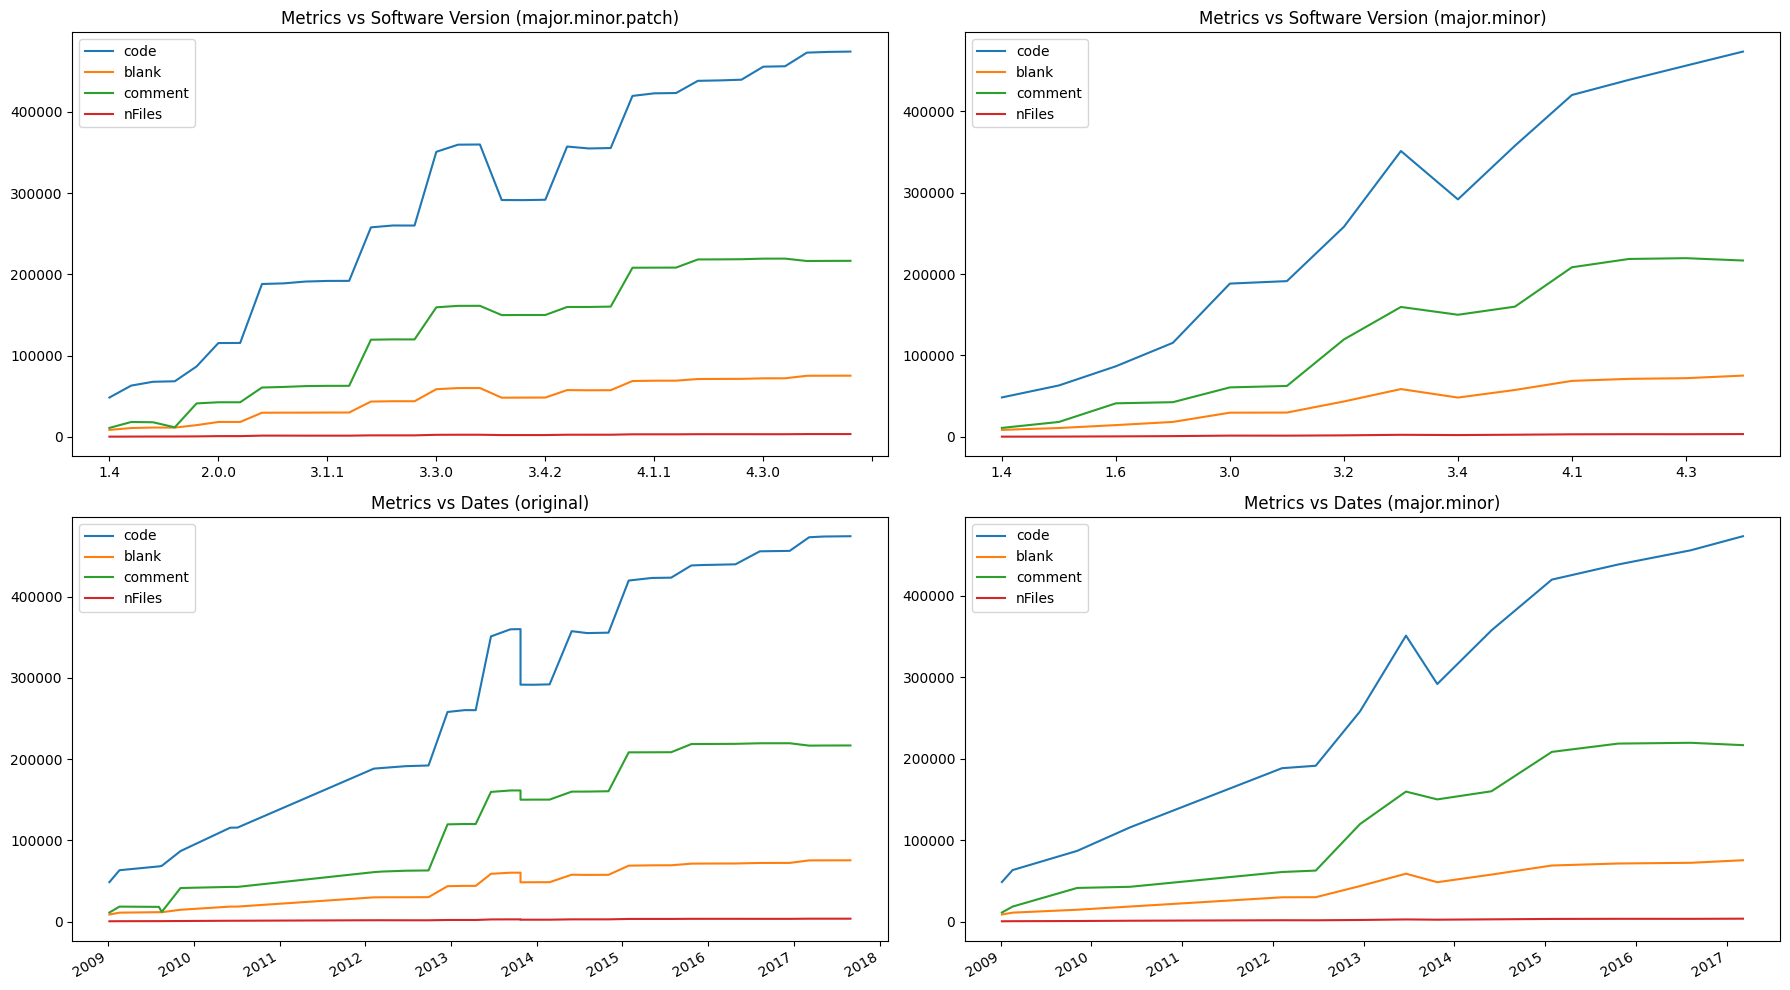

In [43]:
# WRITE YOUR CODE HERE

df = semantic_version_df
# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Plot metrics against software version numbers
df[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag', ax=axes[0, 0], legend=True)
# df['major_minor'] = df['tag'].str.extract(r'^(\d+\.\d+)')

earliest_versions[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag', ax=axes[0, 1], legend=True)
# earliest_versions['major_minor'] = earliest_versions['tag'].str.extract(r'^(\d+\.\d+)')
# df.groupby('major_minor').mean()[['code', 'blank', 'comment', 'nFiles']].plot(ax=axes[0, 1], legend=True)

# Plot metrics against dates
df[['code', 'blank', 'comment', 'nFiles', 'release_date']].plot(x='release_date', ax=axes[1, 0], legend=True)

earliest_versions[['code', 'blank', 'comment', 'nFiles', 'release_date']].plot(x='release_date', ax=axes[1, 1], legend=True)



# Set titles and labels
axes[0, 0].set_title('Metrics vs Software Version (major.minor.patch)')
axes[0, 1].set_title('Metrics vs Software Version (major.minor)')
axes[1, 0].set_title('Metrics vs Dates (original)')
axes[1, 1].set_title('Metrics vs Dates (major.minor)')

for ax in axes.flatten():
    ax.set_xlabel('')  # Remove x-labels to prevent overlap

plt.tight_layout()
plt.show()

### Questions:

1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

They are the same but those below looks more compressed, maybe due to the conversion from tag to date

2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

Date in x-axis is more relevant to see the evolution because tags can be changed over time and previous versions can be patched

### Correlation 

Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering **Dataset A**. Report the correlation upto 3 decimal places.

In [44]:
# WRITE YOUR CODE HERE
spearman_corr = df[['code', 'nFiles']].corr(method='spearman').iloc[0, 1]
pearson_corr = df[['code', 'nFiles']].corr(method='pearson').iloc[0, 1]

print(spearman_corr)
print(pearson_corr)

0.9857083678724862
0.9975956027254002


### Questions:

3. Do you find any difference in correlation values between Pearson and Spearman? Which correlation measure is preferable for this use case? why?

They are nearly the same (0.997 and 0.985). I think that spearman is more appropriate because it is less sensible to outliers and do not suppose a specific data distribution.

4. Based on the above correlation value, please give your opinion on the relation between the number of lines and the number of files? Which of both size metrics do you propose to use in the remainder of your analysis?

The number of lines is more relevant of the complexity of the program

### Regression analysis

Visualize a linear regression analysis of the relationship between the release date and the total number of files by considering **Dataset B**.  

Hint:

1. Prepare the data: Convert the release date to integers and set number of files as the target variable.  
2. Apply linear regression analysis to understand the relationship between the release date and the total number of files.  
3. Calculate Mean Relative Error and ajusted R-squared metrics.    
4. Generate a scatter plot showing the release dates against the total number of files. Then, overlay the linear regression line on the plot.


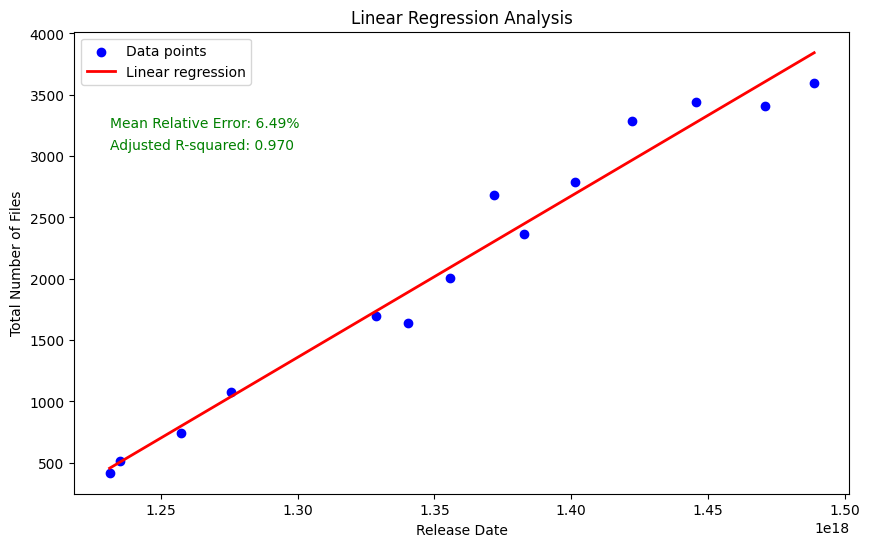

In [50]:
# WRITE YOUR CODE HERE
from sklearn.metrics import r2_score

df_b = earliest_versions 

# Convert release date to integers
df_b['release_date'] = pd.to_datetime(df_b['release_date']).astype(int)

# Prepare the data for linear regression
X = df_b['release_date'].values.reshape(-1, 1)  # Feature matrix
y = df_b['nFiles'].values  # Target variable

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Calculate Mean Relative Error
mean_relative_error = np.mean(np.abs((y - y_pred) / y)) * 100

# Calculate adjusted R-squared
n = len(y)
p = 1  # Number of predictors (one for release date)
r_squared = r2_score(y, y_pred)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Plot release dates against total number of files
plt.figure(figsize=(10, 6))
plt.scatter(df_b['release_date'], df_b['nFiles'], color='blue', label='Data points')
plt.plot(df_b['release_date'], y_pred, color='red', linewidth=2, label='Linear regression')
plt.xlabel('Release Date')
plt.ylabel('Total Number of Files')
plt.title('Linear Regression Analysis')
plt.legend()

# Annotate Mean Relative Error and adjusted R-squared
plt.text(df_b['release_date'].min(), df_b['nFiles'].max()*0.9, f'Mean Relative Error: {mean_relative_error:.2f}%', fontsize=10, color='green')
plt.text(df_b['release_date'].min(), df_b['nFiles'].max()*0.85, f'Adjusted R-squared: {adjusted_r_squared:.3f}', fontsize=10, color='green')

# Show plot
plt.show()


### Questions:

5. Choose an option regarding the growth of the software. Motivate your choice using the 2D regression plot.  
    a) Linear  
    b) Sub-linear  
    c) Super-linear  

6. Report the MRE and ajusted R-squared values.

### Fitting & forecasting

Using **Dataset A**, apply parametric regression models (e.g., linear, exponential, power, quadratic, logarithmic) to predict the number of files in software releases based on historical data.

**Steps:**

1. Prepare Data:
   - Convert "release_date" to datetime format.
   - Calculate "release_days" as the number of days since the earliest release.

2. Split Data:
   - Separate data into features (release days) and target variable (number of files).
   - Split data into training and testing sets from the earliest release up to a specific point.

3. Build and Train Models:
   - Define regression models.
   - Fit models to training data (maybe using `curve_fit` from SciPy).

4. Forecast Future Data:
   - Predict the number of files for future release days using trained models.

5. Visualize Results:
   - Plot original data and forecasted values for each regression model.

6. Evaluate Models:
   - Calculate adjusted R-squared and mean relative error for each model using training and test data.

In [ ]:
# WRITE YOUR CODE HERE

In [ ]:
# WRITE YOUR CODE HERE

In [ ]:
# WRITE YOUR CODE HERE

In [ ]:
# WRITE YOUR CODE HERE

In [ ]:
# WRITE YOUR CODE HERE

In [ ]:
# WRITE YOUR CODE HERE

### Questions:

7. Which regression model do you prefer for assessing the goodness of fit, based on the evaluation metrics scores? Why?

8. Which regression model do you prefer for assessing forecast accuracy, based on the evaluation metrics scores? Why?

### Modify the CLOC parameters

Exclude all bank lines and verify if the Law of Increasing Growth applies after this filtering

In [ ]:
# WRITE YOUR CODE HERE

Exclude all comment lines and verify if the Law of Increasing Growth applies after this filtering

In [ ]:
# WRITE YOUR CODE HERE

## 3. Law of Continuing Change

### Dataset A : Major.Minor.Patch tag format

Import Dataset A that contains number of lines of code that are added, modified, removed and same between two consecutive tags for the three component versions (major.minor.patch)

In [ ]:
# WRITE YOUR CODE HERE

Create a plot displaying all features together. Show the outcomes with dates on the x-axis and the corresponding numbers on the y-axis.

In [ ]:
# WRITE YOUR CODE HERE

### Dataset B : Major.Minor tag format

Import Dataset B that contains number of lines of code that are added, modified, removed and same between two consecutive tags for the minor versions (major.minor)

In [ ]:
# WRITE YOUR CODE HERE

Produce a plot where all features are represented together. Present the outcomes with dates on the x-axis and the corresponding numbers on the y-axis.

In [ ]:
# WRITE YOUR CODE HERE

### Question:

1. Do you find empirical support for the Law of Continuing Change ? Motivate your response.